***Total: 42 points***

Complete this homework by writing R code to complete the following tasks. Keep in mind:

i. Empty chunks have been included where code is required
ii. For Problem 2e, you should include a image (screen shot), which can be loaded into R
iii. This homework requires use of data files:

  - `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` (Problems 1, 2)
  - `GIAB_highconf_v.3.3.2.vcf.gz` (Problem 3)
  
iv. You will be graded on your code and output results (knitted .html file). The assignment is worth 42 points total; partial credit can be awarded.

This assignment is due on **Dec 1, 2022**. 

For additional resources, please refer to these links:  
Problems 1 & 2:  
  - https://www.bioconductor.org/packages/devel/bioc/vignettes/plyranges/inst/doc/an-introduction.html
  - https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html  
Problem 3:  
  - https://bioconductor.org/packages/release/bioc/vignettes/Rsamtools/inst/doc/Rsamtools-Overview.pdf  
Problem 4: 
  - https://bioconductor.org/packages/release/bioc/vignettes/VariantAnnotation/inst/doc/VariantAnnotation.pdf  

# Problem 1: Overlaps between genomic regions and copy number alterations. (14 points total)

### Preparation
Load copy number segment results as shown in *2.1 BED format* of *Lecture16_GenomicData.Rmd*. You will use the same file as in the lecture notes, `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg`. Here is code to get you started.

In [174]:
#load packages
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(plyranges)
    library(VariantAnnotation)
    library(dplyr)
})

In [69]:
#old wdir
getwd()

#new wdir
data_dir = '/workspaces/tfcb_2022/homeworks/homework07'
setwd(data_dir)
getwd()

[1] "/workspaces/tfcb_2022/homeworks/homework07"

[1] "/workspaces/tfcb_2022/homeworks/homework07"

In [70]:
list.files()

[1] "BRCA_IDC_cfDNA.bam"                           
 [2] "BRCA_IDC_cfDNA.bam.bai"                       
 [3] "BRCA.genome_wide_snp_6_broad_Level_3_scna.seg"
 [4] "GIAB_highconf_v.3.3.2.vcf.gz"                 
 [5] "GIAB_highconf_v.3.3.2.vcf.gz.tbi"             
 [6] "Homework07.ipynb"                             
 [7] "homework07.Rmd"                               
 [8] "hs37d5.fa"                                    
 [9] "hs37d5.fa.gz.fai"                             
[10] "README.md"

In [71]:
segs <- read.delim("BRCA.genome_wide_snp_6_broad_Level_3_scna.seg", as.is = TRUE)
mode(segs$Chromosome) <- "character" 
segs[segs$Chromosome == 23, "Chromosome"] <- "X"
segs.gr <- as(segs, "GRanges")

### a. Find the segments in `segs.gr` that have *any* overlap with the region `chr8:128,746,347-128,755,810` (4 points)
Print out the first five unique TCGA IDs.

In [72]:
#make new GRanges with chromosome/DNA coordinates of interest
myGRange <- GRanges(seqnames = "8",
                    ranges = IRanges(start = 128746347, end = 128755810))
#find overlap of the sequences with the Grange and convert to dataframe
segs.overlap <- find_overlaps(segs.gr, myGRange) %>%
    as.data.frame()  # arguments: find_overlaps(query, subject)
#print the first 5 Sample (TCGA) IDs
print (segs.overlap$Sample[1:5])

[1] "TCGA-3C-AAAU-10A-01D-A41E-01" "TCGA-3C-AAAU-01A-11D-A41E-01"
[3] "TCGA-3C-AALI-10A-01D-A41E-01" "TCGA-3C-AALI-01A-11D-A41E-01"
[5] "TCGA-3C-AALJ-10A-01D-A41E-01"


### b. Find the mean of the `Segment_Mean` values for copy number segments that have *any* overlap with the region chr17:37,842,337-37,886,915. (4 points)

In [73]:
#make new GRanges with chromosome/DNA coordinates of interest
myGRange_1b <- GRanges(seqnames = "17",
                    ranges = IRanges(start = 37842337, end = 37886915))
#find overlap of the sequences with the Grange and convert to dataframe
segs.overlap_1b <- find_overlaps(segs.gr, myGRange_1b) %>%
    as.data.frame() 
#take mean of all the segment means from the sequence overlap dataframe
mean(segs.overlap_1b$Segment_Mean)

[1] 0.1420197

### c. Find the patient sample distribution of copy number for `PIK3CA` (hg19). (6 points)
Find the counts of samples with deletion (D; `Segment_Mean < -0.3`), neutral (N; `Segment_Mean >= -0.3 & Segment_Mean <= 0.3`), gain (G; `Segment_Mean > 0.3`) segments that have `any` overlap with `PIK3CA` gene coordinates.  


In [74]:
#make new GRanges with chromosome/DNA coordinates for PIK3CA gene
myGRange_PIK3CA <- GRanges(seqnames = "3",
                    ranges = IRanges(start = 179148126, end = 179240093))
#find overlap of the sequences with the Grange and convert to dataframe
segs.overlap_PIK3CA <- find_overlaps(segs.gr, myGRange_PIK3CA) %>%
    as.data.frame()

#filter the overlap dataframe for Segment_mean less than -0.3 to find deletion segments
deletion_seqs <- segs.overlap_PIK3CA %>%
    filter(Segment_Mean < -0.3)
#count the number of samples with deletions by counting the rows using nrow
del <- nrow(deletion_seqs)
sprintf('The counts of samples with deletion segments is %s.', del)

#filter the overlap dataframe for Segment_mean between -0.3 and 0.3 to find neutral segments
neutral_seqs <- segs.overlap_PIK3CA %>%
    filter(Segment_Mean >= -0.3 & Segment_Mean <= 0.3)
#count the number of neutral samples by counting the rows using nrow
neutral <- nrow(neutral_seqs)
sprintf('The counts of samples with neutral segments is %s.', neutral)

#filter the overlap dataframe for Segment_mean greater than 0.3 to find gain segments
gain_seqs <- segs.overlap_PIK3CA %>%
    filter(Segment_Mean > 0.3)
#count the number of samples with gains by counting the rows using nrow
gain <- nrow(gain_seqs)
sprintf('The counts of samples with gain segments is %s.', gain)

[1] "The counts of samples with deletion segments is 14."

[1] "The counts of samples with neutral segments is 2024."

[1] "The counts of samples with gain segments is 165."

# Problem 2: Frequency of copy number alteration events within genomic regions. (12 points total) 

This problem will continue to use the copy number data stored in `segs.gr`.

### a. Create a genome-wide tile of 1Mb windows for the human genome (`hg19`). (4 points)
See *3.1 Tiling the genome* of *Lecture16_GenomicData.Rmd* for hints.


In [75]:
#read in the reference genome
seqinfo <- Seqinfo(genome = "hg19")
#only want to keep standard chromosomes
seqinfo <- keepStandardChromosomes(seqinfo) 
#use NCBI chromosome naming convention by setting seqlevelsStyle
seqlevelsStyle(seqinfo) <- "NCBI"
slen <- seqlengths(seqinfo) #get the length of the chromosomes
tileWidth <- 1000000 #tile size of 1Mb
#make the tiles
tiles <- tileGenome(seqlengths = slen, tilewidth = tileWidth,
                    cut.last.tile.in.chrom = TRUE)

Warning message in (function (seqlevels, genome, new_style) :
“cannot switch some of hg19's seqlevels from UCSC to NCBI style”


GRanges object with 3114 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]        1         1-1000000      *
     [2]        1   1000001-2000000      *
     [3]        1   2000001-3000000      *
     [4]        1   3000001-4000000      *
     [5]        1   4000001-5000000      *
     ...      ...               ...    ...
  [3110]        Y 56000001-57000000      *
  [3111]        Y 57000001-58000000      *
  [3112]        Y 58000001-59000000      *
  [3113]        Y 59000001-59373566      *
  [3114]     chrM           1-16571      *
  -------
  seqinfo: 25 sequences from an unspecified genome

### b. Find the 1Mb window with the most frequent overlapping deletions. (4 points)
Find the 1Mb windows with `any` overlap with deletion copy number segments. Assume a deletion segment is defined as a segment in `segs.gr` having `Segment_Mean < -0.3`. 

Return one of the 1Mb window `Granges` entry with the highest frequency (count) of deletion segments.

Hint: Subset the `segs.gr` to only rows with `Segment_Mean < -0.3`. 

In [188]:
#filter segs.gr to only deletions so less than -0.3 Segment_Mean
segs.grdel<- segs.gr %>%
  filter(Segment_Mean < -0.3)

#find overlap of the 1Mb tiles with the sequence segmengs and convert to dataframe
segs.overlap_del <- find_overlaps(tiles, segs.grdel) %>%
  as.data.frame()

#group the find overlap dataframe by seq(chromosome), start, and end and summarise to find the count or frequency for each tile
max_count <- segs.overlap_del %>% 
  group_by(seqnames, start, end) %>%
  summarise(counts = n()) 
#filter for tiles with the max number of counts/deletion segments
max_count %>% filter (counts == max(max_count$counts))

`summarise()` has grouped output by 'seqnames', 'start'. You can override using
the `.groups` argument.


seqnames,start,end,counts
<fct>,<int>,<int>,<int>
16,79000001,80000000,620
16,83000001,84000000,620


### c. Visually inspect the deletion overlap result from part (b) using IGV. (4 points)
Provide a screen shot of IGV at the 1Mb window with the most frequent overlap with deletion segments. The image should include the segments from `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` loaded. 

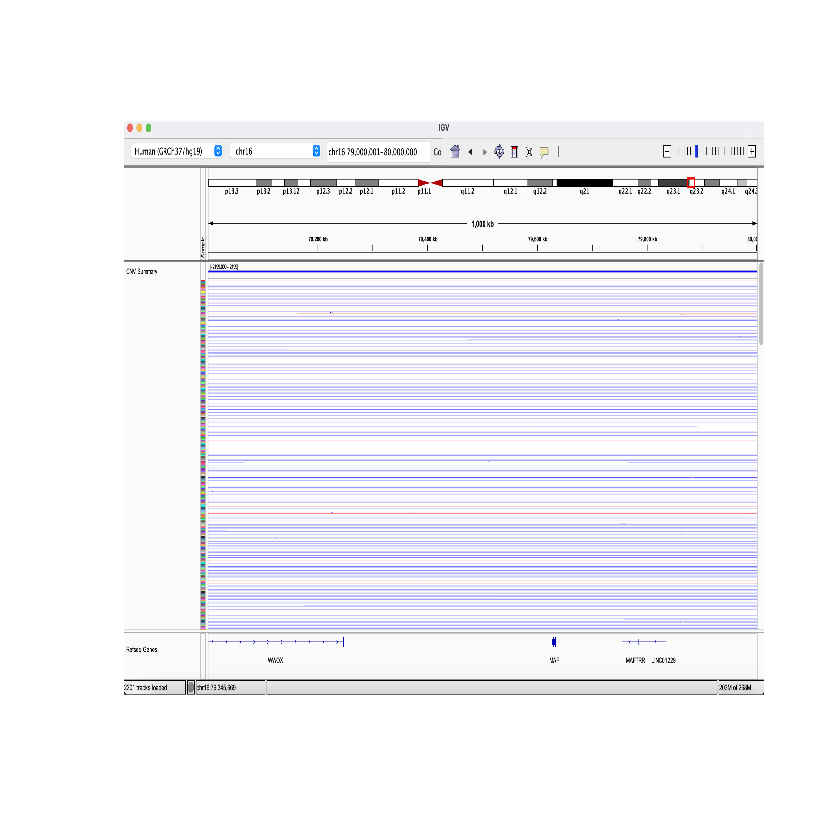

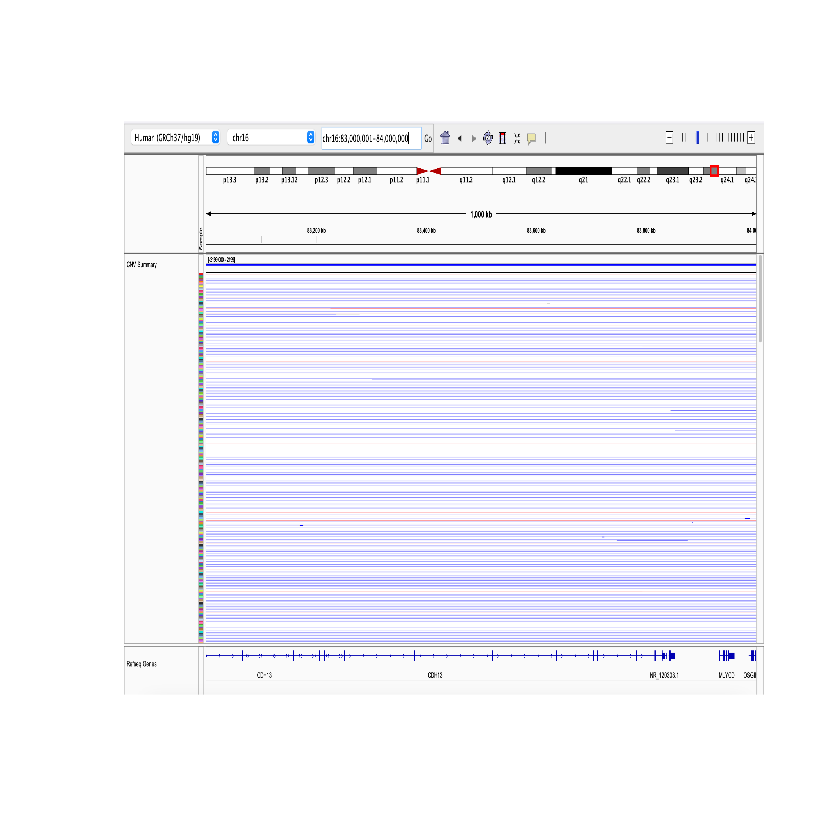

In [192]:
#save screenshot and load into R with png package (see: https://stackoverflow.com/questions/23861000/displaying-images-in-r-in-version-3-1-0)
#load png package
library(png)
#load in screenshot from igv chr16:79,000,001-80,000,000
pp <- readPNG("IGV_1.png")
plot.new() 
rasterImage(pp,0,0,1,1)

#load in screenshot from igv chr16:83,000,001-84,000,000
pp2 <- readPNG("IGV_2.png")
plot.new() 
rasterImage(pp2,0,0,1,1)

# Problem 3: Reading and annotating genomic variants (16 points total)

### Preparation

In [193]:
vcfFile <- "GIAB_highconf_v.3.3.2.vcf.gz"

### a. Load variant data from VCF file `GIAB_highconf_v.3.3.2.vcf.gz` for `chr8:128,700,000-129,000,000`. (4 points)
Note: use genome build `hg19`.

In [194]:
#set up VCF parameters
vcfHead <- scanVcfHeader(vcfFile)
#make new GRanges with chromosome/DNA coordinates of interest
myGRange_vcf <- GRanges(seqnames = "8", ranges = IRanges(start = 128700000, end = 129000000))
vcf.param <- ScanVcfParam(which = myGRange_vcf) 
#read VCF files
vcf <- readVcf(vcfFile, genome = "hg19", param = vcf.param)

### b. Combine the fields of the VCF genotype information into a table. (4 points)
You may use your choice of data objects (e.g. `data.frame`).

In [196]:
#combine all `geno` fields into a single table
genoData <- data.frame(do.call(cbind, geno(vcf)))
colnames(genoData) <- rownames(geno(header(vcf)))
genoData

,GT,DP,GQ,ADALL,AD,IGT,IPS,PS
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>
rs6984323,1|1,765,583,"1, 332","0, 315",1/1,.,PATMAT
rs4478537,0|1,544,813,"103, 124","135, 172",0/1,.,PATMAT
rs34141920,0|1,523,222,"132, 121","132, 121",0/1,.,PATMAT
rs17772814,1|0,695,1503,"143, 158","196, 199",0/1,.,PATMAT
rs77977256,1|0,642,685,"154, 157","160, 166",0/1,.,PATMAT
8:128715845_AT/A,0|1,368,99,"66, 91","66, 91",0/1,.,PATMAT
rs143209301,1|0,581,595,"128, 128","151, 165",0/1,.,PATMAT
rs202231913,0|1,369,99,"81, 97","81, 97",0/1,.,PATMAT
rs16902340,0|1,689,1294,"144, 150","184, 204",0/1,.,PATMAT


### c. Retrieve the following information at chr8:128747953. (8 points)
Print out the SNP ID (i.e. "rs ID"), reference base (`REF`), alterate base (`ALT`), genotype (`GT`), depth (`DP`), allele depth (`ADALL`), phase set (`PS`).

Hints: 

  i. `REF` and `ALT` are in the output of `rowRanges(vcf)`. See Section `3a` in `Lecture16_VariantCalls.ipynb` 
  ii. To get the sequence of `DNAString`, use `as.character(x)`.  
  ii. To get the sequence of `DNAStringSet`, use `as.character(unlist(x))`. 
  iii. To expand a list of information for `geno`, use `unlist(x)`.  

  

In [ ]:
#make new GRanges with chromosome/DNA coordinate of interest
myGRange_3c <- GRanges(seqnames = '8', ranges = IRanges(start = 128747953, end = 128747953))
#setup vcf parameters
vcf.param_3c <- ScanVcfParam(which = myGRange_3c)
#read VCF files
vcf_3c <- readVcf(vcfFile, genome = "hg19", param = vcf.param_3c)

#combine all `geno` fields into a single table
genoData_3c <- data.frame(do.call(cbind, geno(vcf_3c)))
colnames(genoData_3c) <- rownames(geno(header(vcf_3c)))

#retrieve desired information
# unlist(geno(newvcf))
# rowRanges(newvcf)